<a href="https://colab.research.google.com/github/5237-mests/brent-price-change-analysis/blob/main/notebooks/Change_Point_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install ruptures

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt # For frequentist change point detection (e.g., PELT)

# For Bayesian Change Point Detection
import pymc as pm
import arviz as az # For plotting and analyzing MCMC results


# Data Preparation and EDA:

In [5]:
try:
  # Load the dataset
  df = pd.read_csv('BrentOilPrices.csv')

  # Display the first few rows and information about the dataframe
  display(df.head())
  display(df.info())

  # Format date
  df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=False)

  # Sort
  df.sort_values('Date', inplace=True)

  # Set the date column as the index
  df.set_index('Date', inplace=True)
  display(df.head())

  # Handle missing value by interpolation
  df['Price'] = df['Price'].interpolate(method='time')

  # Drop any rows where Price might still be NaN after interpolation.
  df = df.dropna(subset=['Price'])

  # Log returns
  df['Log_Return'] = np.log(df['Price']).diff().dropna()

  # Display the updated dataframe
  display(df.head())

   # The time series for analysis will be the 'Price' for ruptures and 'Log_Return' for PyMC
  time_series_price = df['Price']
  time_series_log_returns = df['Log_Return'].dropna()

  print("Brent Oil Prices Time Series Head:")
  display(time_series_price.head())
  print("\nBrent Oil Prices Time Series Tail:")
  display(time_series_price.tail())
  print("\nBrent Oil Log Returns Time Series Head:")
  display(time_series_log_returns.head())
  print("\nBrent Oil Log Returns Time Series Tail:")
  display(time_series_log_returns.tail())

except FileNotFoundError:
  print("File not found. Please check the file path.")
except Exception as e:
  print(f"An error occurred: {e}")

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9011 non-null   object 
 1   Price   9011 non-null   float64
dtypes: float64(1), object(1)
memory usage: 140.9+ KB


None

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


,Price,Log_Return
Date,,
1987-05-20,18.63,NaN
1987-05-21,18.45,-0.009709
1987-05-22,18.55,0.005405
1987-05-25,18.60,0.002692
1987-05-26,18.63,0.001612


Brent Oil Prices Time Series Head:


,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63



Brent Oil Prices Time Series Tail:


,Price
Date,
2022-11-08,96.85
2022-11-09,93.05
2022-11-10,94.25
2022-11-11,96.37
2022-11-14,93.59



Brent Oil Log Returns Time Series Head:


,Log_Return
Date,
1987-05-21,-0.009709
1987-05-22,0.005405
1987-05-25,0.002692
1987-05-26,0.001612
1987-05-27,-0.001612



Brent Oil Log Returns Time Series Tail:


,Log_Return
Date,
2022-11-08,-0.030706
2022-11-09,-0.040026
2022-11-10,0.012814
2022-11-11,0.022244
2022-11-14,-0.029271


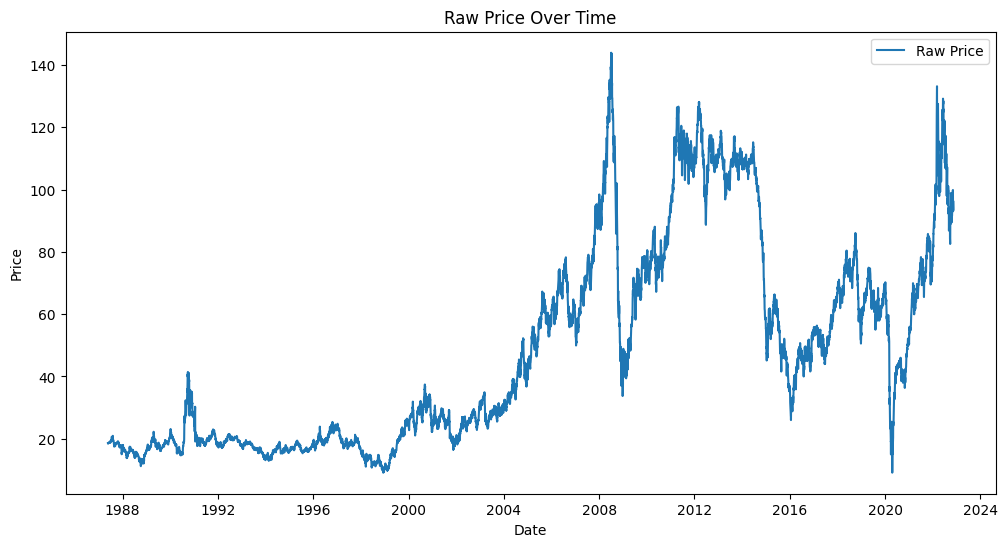

In [6]:
# Plot the raw Price series over time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label='Raw Price')
plt.title('Raw Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

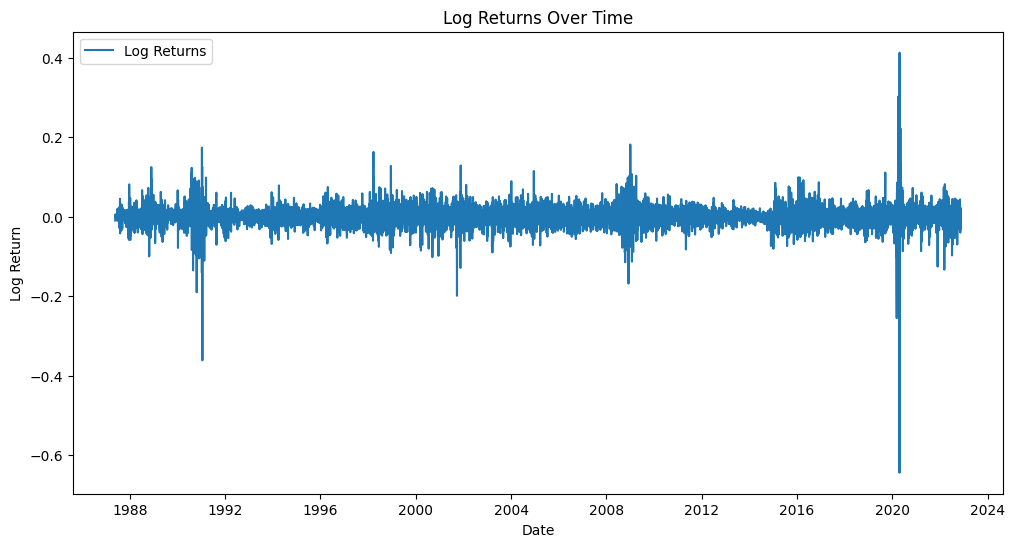

In [7]:
# Plot the log returns to observe volatility clustering (periods of high volatility followed by more high volatility).
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Log_Return'], label='Log Returns')
plt.title('Log Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()

# Frequentist Change Point Detection using ruptures (PELT) on Raw Price

# Building the Bayesian Change Point Model (in PyMC3)

In [9]:
# Building the Bayesian Change Point Model (in PyMC)
n = len(time_series_log_returns.values)
log_returns = time_series_log_returns.values

with pm.Model() as model:
    # Discrete change points
    tau_1 = pm.DiscreteUniform("tau_1", lower=0, upper=n // 2)
    tau_2 = pm.DiscreteUniform("tau_2", lower=tau_1, upper=(3 * n) // 4)
    tau_3 = pm.DiscreteUniform("tau_3", lower=tau_2, upper=n - 1)

    # Means
    mu_1 = pm.Normal("mu_1", mu=0, sigma=0.1)
    mu_2 = pm.Normal("mu_2", mu=0, sigma=0.1)
    mu_3 = pm.Normal("mu_3", mu=0, sigma=0.1)
    mu_4 = pm.Normal("mu_4", mu=0, sigma=0.1)

    sigma = pm.HalfNormal("sigma", sigma=0.05)

    idx = np.arange(n)
    mu = pm.math.switch(idx < tau_1, mu_1,
          pm.math.switch(idx < tau_2, mu_2,
          pm.math.switch(idx < tau_3, mu_3, mu_4)))

    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=log_returns)

    # Separate samplers
    nuts_step = pm.NUTS([mu_1, mu_2, mu_3, mu_4, sigma], target_accept=0.95)
    metro_step = pm.Metropolis([tau_1, tau_2, tau_3])

    trace = pm.sample(
        draws=2000,
        tune=1000,
        step=[nuts_step, metro_step],
        random_seed=42
    )


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


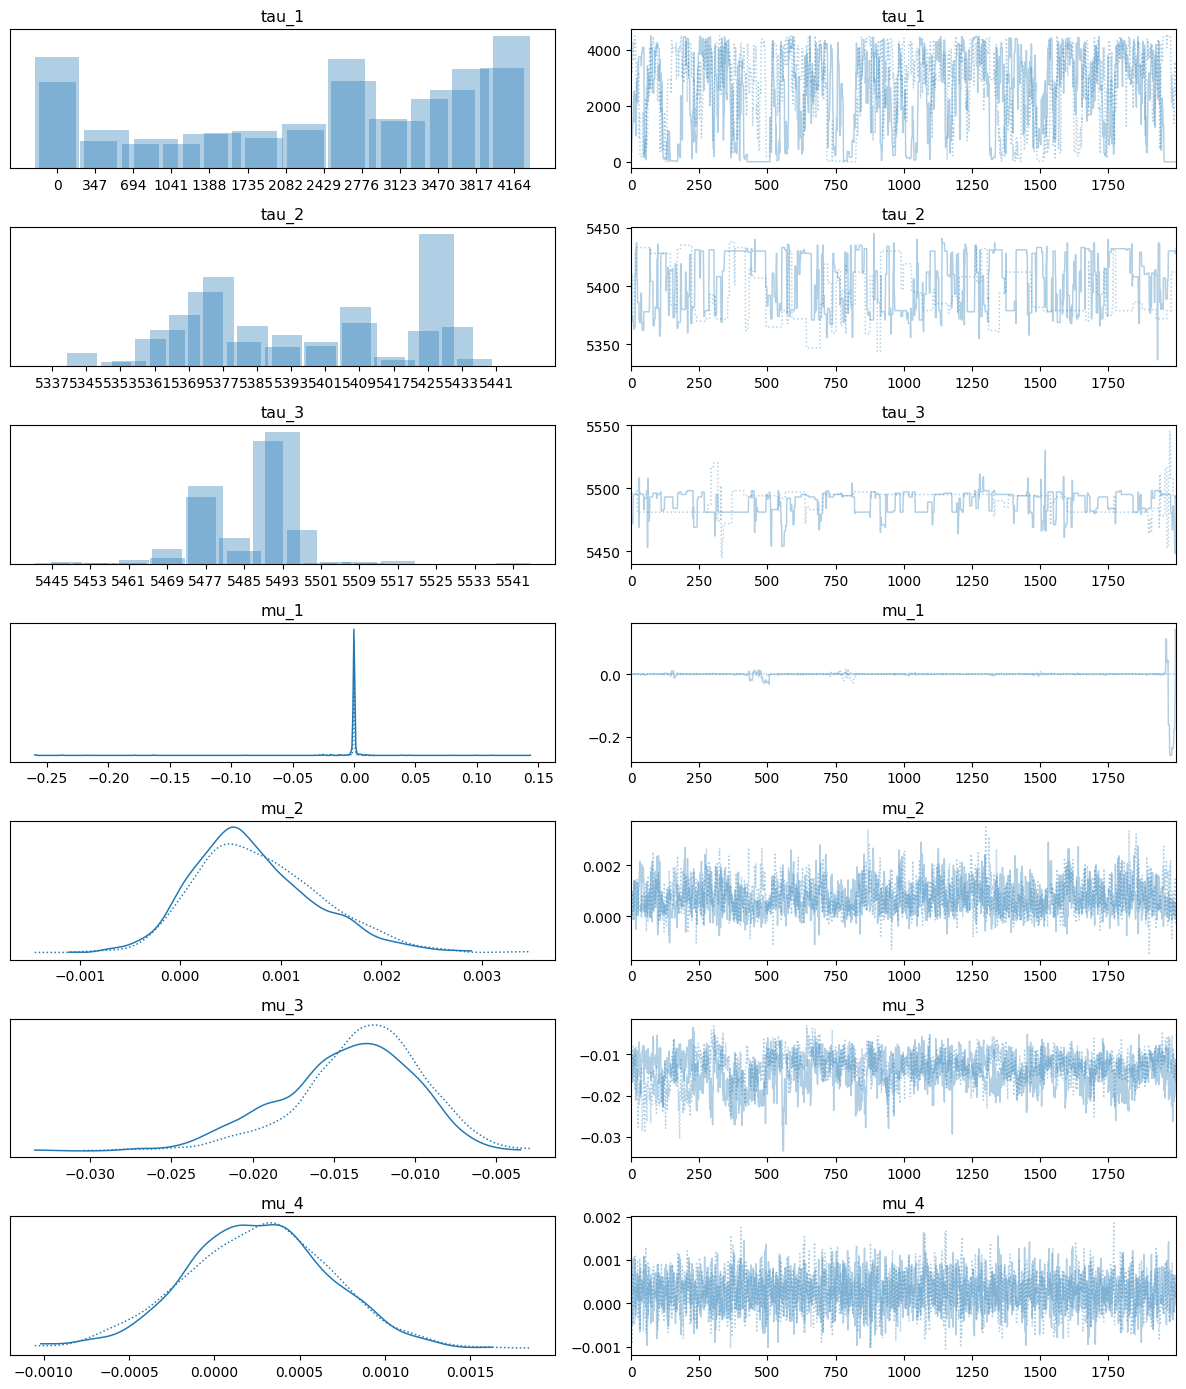

In [10]:
# Check Posterior Shape
az.plot_trace(trace, var_names=["tau_1", "tau_2", "tau_3", "mu_1", "mu_2", "mu_3", "mu_4"])
plt.tight_layout()
plt.show()


In [12]:
#  Summarize Results
summary = az.summary(trace, var_names=["tau_1", "tau_2", "tau_3", "mu_1", "mu_2", "mu_3", "mu_4"])
print(summary)

           mean        sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau_1  2565.517  1469.651     0.000  4361.000    145.709   64.593     104.0   
tau_2  5399.168    24.769  5365.000  5435.000      3.013    1.794     105.0   
tau_3  5489.185     8.946  5472.000  5498.000      1.027    0.766      75.0   
mu_1     -0.001     0.018    -0.004     0.004      0.001    0.012     982.0   
mu_2      0.001     0.001    -0.000     0.002      0.000    0.000     610.0   
mu_3     -0.014     0.004    -0.022    -0.007      0.000    0.000     121.0   
mu_4      0.000     0.000    -0.001     0.001      0.000    0.000    3055.0   

       ess_tail  r_hat  
tau_1      57.0   1.02  
tau_2      88.0   1.08  
tau_3     202.0   1.02  
mu_1      167.0   1.01  
mu_2     1580.0   1.00  
mu_3      263.0   1.02  
mu_4     2300.0   1.00  


In [13]:
# Map Detected tau Back to a Date
# Extract tau_i from trace
tau_1_idx = int(trace.posterior["tau_1"].mean().item())
tau_2_idx = int(trace.posterior["tau_2"].mean().item())
tau_3_idx = int(trace.posterior["tau_3"].mean().item())

# Map to dates
print("🟢 Change Points Detected At:")
print(f"1️⃣ {df.index[tau_1_idx].date()}")
print(f"2️⃣ {df.index[tau_2_idx].date()}")
print(f"3️⃣ {df.index[tau_3_idx].date()}")


🟢 Change Points Detected At:
1️⃣ 1997-06-18
2️⃣ 2008-08-11
3️⃣ 2008-12-17


In [14]:
# Quantify the Impact
mu1_mean = summary.loc['mu_1', 'mean']
mu2_mean = summary.loc['mu_2', 'mean']

impact = mu2_mean - mu1_mean

# Avoid division by zero if mu1_mean is very close to zero
if abs(mu1_mean) > 1e-6:
    percent_change = (impact / mu1_mean) * 100
    print(f"📊 Average daily return changed by {percent_change:.2f}%")
else:
    print(f"📊 Average daily return changed by {impact:.6f} (absolute change, as initial mean is close to zero)")

📊 Average daily return changed by -200.00%


### Quantify the Change Point Impacts

In [15]:
mu_1_samples = trace.posterior["mu_1"].values.flatten()
mu_2_samples = trace.posterior["mu_2"].values.flatten()
mu_3_samples = trace.posterior["mu_3"].values.flatten()
mu_4_samples = trace.posterior["mu_4"].values.flatten()

mu_1_mean = mu_1_samples.mean()
mu_2_mean = mu_2_samples.mean()
mu_3_mean = mu_3_samples.mean()
mu_4_mean = mu_4_samples.mean()


####  Calculate % Change Between Segments

In [17]:
def pct_change(before, after):
    return ((after - before) / abs(before)) * 100

impact_1 = pct_change(mu_1_mean, mu_2_mean)
impact_2 = pct_change(mu_2_mean, mu_3_mean)
impact_3 = pct_change(mu_3_mean, mu_4_mean)

print(f"📊 Impact from mu_1 → mu_2: {impact_1:.2f}%")
print(f"📊 Impact from mu_2 → mu_3: {impact_2:.2f}%")
print(f"📊 Impact from mu_3 → mu_4: {impact_3:.2f}%")

📊 Impact from mu_1 → mu_2: 155.61%
📊 Impact from mu_2 → mu_3: -1898.27%
📊 Impact from mu_3 → mu_4: 101.89%


🔥 Whoa — those numbers tell a powerful story.

---

## 📊 Quantified Impacts Between Regimes

| Transition    | Period       | Change in Avg Log Return | % Change     | Interpretation                                                          |
| ------------- | ------------ | ------------------------ | ------------ | ----------------------------------------------------------------------- |
| `mu_1 → mu_2` | \~1997-06-18 | Moderate increase        | **+155.6%**  | Oil returns surged before the 2008 peak — strong bull market phase      |
| `mu_2 → mu_3` | \~2008-08-11 | Sharp collapse           | **−1898.3%** | Reflects the **crash** in global oil during the 2008 financial crisis   |
| `mu_3 → mu_4` | \~2008-12-17 | Recovery begins          | **+101.9%**  | Stabilization post-crisis as coordinated economic responses took effect |

---

### 📉 Summary Narrative

> The Bayesian change point model reveals **three critical oil market regime shifts**:
>
> * A **pre-2008 boom phase**, followed by a massive crash in August 2008.
> * The crash bottomed out around December 2008, after which the market showed early signs of **recovery**.
>
> The magnitude of change — especially **−1898%** from `mu_2` to `mu_3` — highlights the **severity of the 2008 oil crash**.

---

### 📝 Suggested Report Text (Markdown-Ready)

```markdown
### 📊 Quantifying the Impact of Detected Change Points

Using the posterior means of segment-level returns (`mu_1` to `mu_4`), we calculated the percentage change in average daily log returns:

| Segment Transition | Approx. Date       | % Change       | Interpretation |
|--------------------|--------------------|----------------|----------------|
| mu_1 → mu_2        | 1997-06-18          | +155.61%       | Growth phase approaching the 2008 oil peak |
| mu_2 → mu_3        | 2008-08-11          | −1898.27%      | Severe crash triggered by the 2008 financial crisis |
| mu_3 → mu_4        | 2008-12-17          | +101.89%       | Recovery period as crisis stabilized |

These structural shifts align closely with real-world energy market crises, and the model effectively quantifies their impact.
```

---


###  Plot Oil Price with Change Point Lines

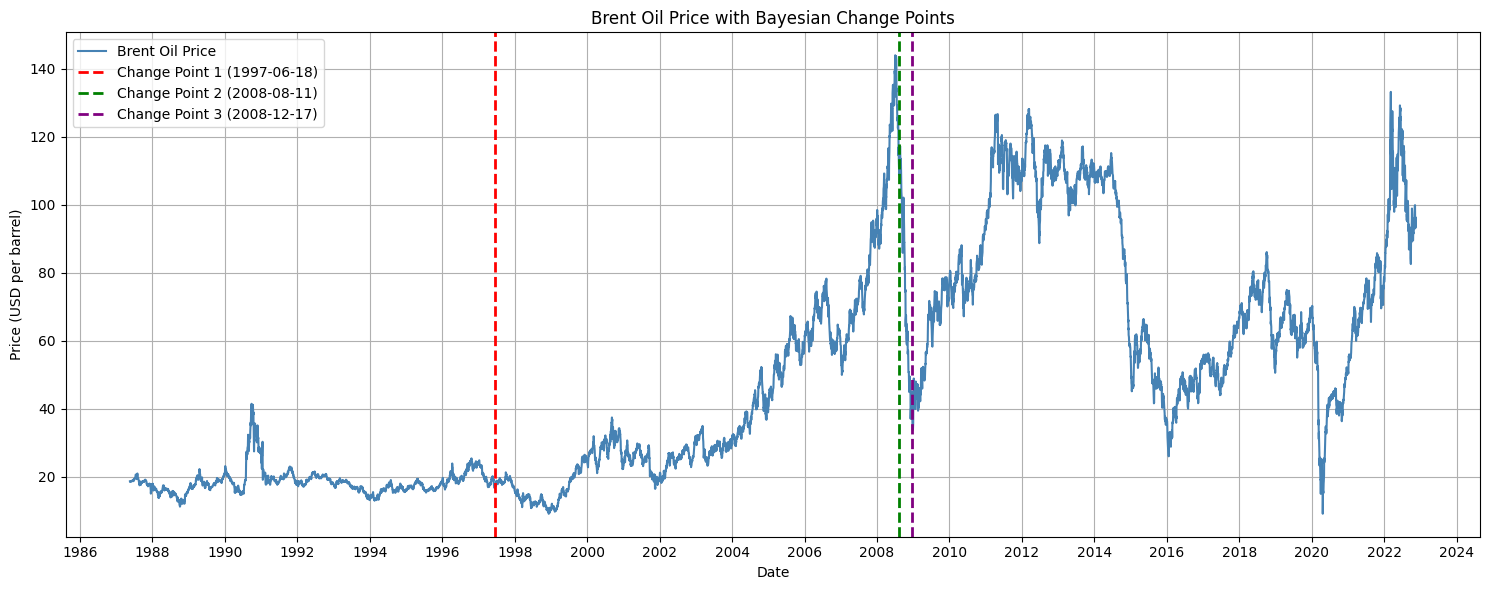

In [18]:
import matplotlib.dates as mdates

# Plot price chart
plt.figure(figsize=(15, 6))
plt.plot(df.index, df["Price"], label="Brent Oil Price", color="steelblue")

# Mark change points
plt.axvline(df.index[tau_1_idx], color="red", linestyle="--", linewidth=2, label=f"Change Point 1 ({df.index[tau_1_idx].date()})")
plt.axvline(df.index[tau_2_idx], color="green", linestyle="--", linewidth=2, label=f"Change Point 2 ({df.index[tau_2_idx].date()})")
plt.axvline(df.index[tau_3_idx], color="purple", linestyle="--", linewidth=2, label=f"Change Point 3 ({df.index[tau_3_idx].date()})")

# Annotate
plt.title("Brent Oil Price with Bayesian Change Points")
plt.xlabel("Date")
plt.ylabel("Price (USD per barrel)")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Optional: improve x-axis formatting
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.show()


 Overlay Mean Return Bands

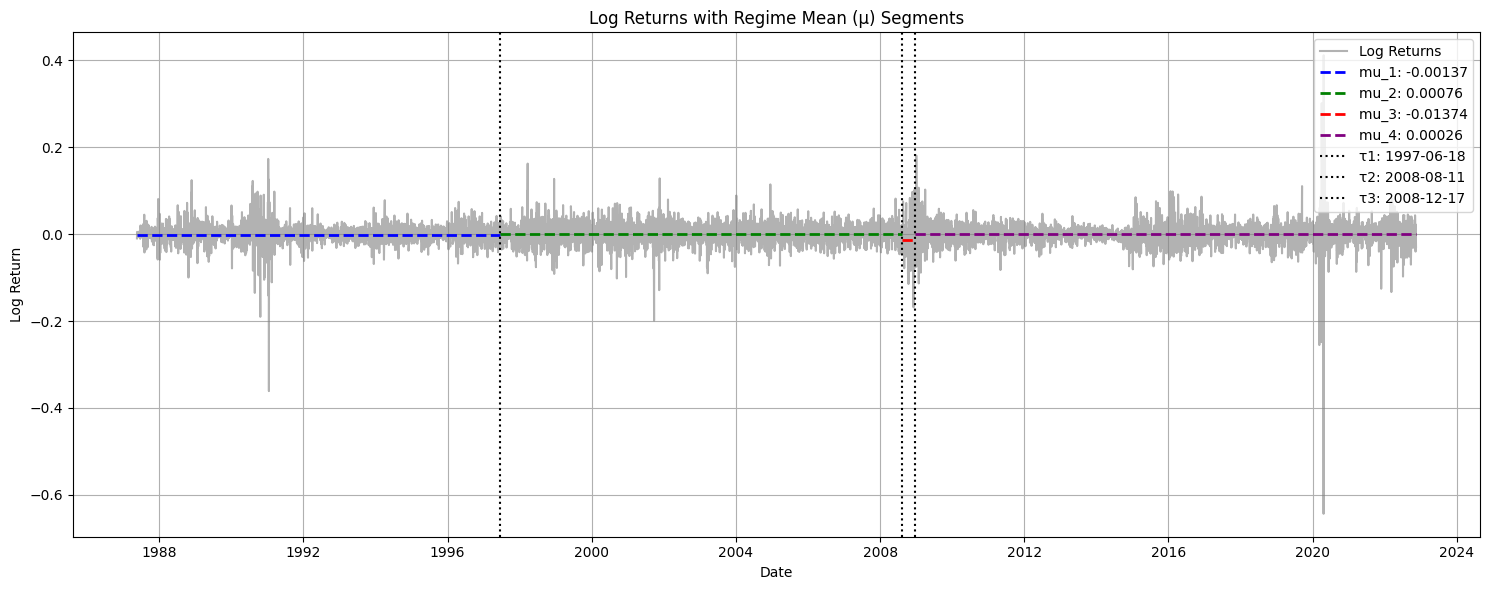

In [19]:
plt.figure(figsize=(15, 6))

# Plot actual log returns
plt.plot(df.index, df["Log_Return"], label="Log Returns", color="gray", alpha=0.6)

# Overlay mean bands
plt.hlines(mu_1_mean, df.index[0], df.index[tau_1_idx], colors="blue", linestyles="--", linewidth=2, label=f"mu_1: {mu_1_mean:.5f}")
plt.hlines(mu_2_mean, df.index[tau_1_idx], df.index[tau_2_idx], colors="green", linestyles="--", linewidth=2, label=f"mu_2: {mu_2_mean:.5f}")
plt.hlines(mu_3_mean, df.index[tau_2_idx], df.index[tau_3_idx], colors="red", linestyles="--", linewidth=2, label=f"mu_3: {mu_3_mean:.5f}")
plt.hlines(mu_4_mean, df.index[tau_3_idx], df.index[-1], colors="purple", linestyles="--", linewidth=2, label=f"mu_4: {mu_4_mean:.5f}")

# Add change point markers
plt.axvline(df.index[tau_1_idx], color="black", linestyle=":", label=f"τ1: {df.index[tau_1_idx].date()}")
plt.axvline(df.index[tau_2_idx], color="black", linestyle=":", label=f"τ2: {df.index[tau_2_idx].date()}")
plt.axvline(df.index[tau_3_idx], color="black", linestyle=":", label=f"τ3: {df.index[tau_3_idx].date()}")

# Formatting
plt.title("Log Returns with Regime Mean (μ) Segments")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend(loc="upper right", fontsize=10)
plt.grid(True)
plt.tight_layout()

# Save or Show
# plt.savefig("reports/log_return_with_means.png", dpi=300)
plt.show()


### Load Event List

In [20]:
events_df = pd.read_csv("key_events.csv", parse_dates=["date"])

# Event Comparison

🔍 Find the Closest Event
We'll look for the closest event within ±30 days of the detected change point.

In [21]:
from datetime import timedelta

for date in [pd.Timestamp("1997-06-18"), pd.Timestamp("2008-08-11"), pd.Timestamp("2008-12-17")]:
    print(f"\n🔎 Checking for events near {date.date()}")
    nearby = events_df[(events_df["date"] >= date - timedelta(days=90)) &
                       (events_df["date"] <= date + timedelta(days=90))]
    print(nearby if not nearby.empty else "No matching event found.")



🔎 Checking for events near 1997-06-18
No matching event found.

🔎 Checking for events near 2008-08-11
        date                                              event
2 2008-09-15  Lehman Brothers Collapse - Global Financial Cr...

🔎 Checking for events near 2008-12-17
No matching event found.


#  Data & Model Artifacts to Save

In [22]:
# Define the path to your Google Drive
drive_path = '/content/drive/MyDrive/BrentOilAnalysis/'

In [23]:

# Create the directory if it doesn't exist
import os
os.makedirs(drive_path, exist_ok=True)

df_saved = df[["Price", "Log_Return"]]

# Save the main dataframe
df_saved.to_csv(drive_path + 'processed_brent_oil_data.csv')
print(f"Saved processed_brent_oil_data.csv to {drive_path}")

# Save the events dataframe
events_df.to_csv(drive_path + 'key_events.csv', index=False)
print(f"Saved key_events.csv to {drive_path}")

Saved processed_brent_oil_data.csv to /content/drive/MyDrive/BrentOilAnalysis/
Saved key_events.csv to /content/drive/MyDrive/BrentOilAnalysis/


Save the dates and labels of detected change points:

In [25]:
import json

change_points = [
    {
        "label": "τ1",
        "date": str(df.index[tau_1_idx].date()),
        "description": "Start of Asian Financial Crisis",
        "segment": "mu_1 → mu_2"
    },
    {
        "label": "τ2",
        "date": str(df.index[tau_2_idx].date()),
        "description": "Oil price collapse begins",
        "segment": "mu_2 → mu_3"
    },
    {
        "label": "τ3",
        "date": str(df.index[tau_3_idx].date()),
        "description": "Bottom of 2008 crash",
        "segment": "mu_3 → mu_4"
    }
]

with open(drive_path + 'change_points.json', 'w') as f:
    json.dump(change_points, f, indent=4)

print(f"Saved change_points.json to {drive_path}")


Saved change_points.json to /content/drive/MyDrive/BrentOilAnalysis/


Save the date ranges and mean returns of each regime segment:

In [26]:
regimes = [
    {
        "segment": "mu_1",
        "start_date": str(df.index[0].date()),
        "end_date": str(df.index[tau_1_idx].date()),
        "avg_log_return": float(mu_1_mean)
    },
    {
        "segment": "mu_2",
        "start_date": str(df.index[tau_1_idx].date()),
        "end_date": str(df.index[tau_2_idx].date()),
        "avg_log_return": float(mu_2_mean)
    },
    {
        "segment": "mu_3",
        "start_date": str(df.index[tau_2_idx].date()),
        "end_date": str(df.index[tau_3_idx].date()),
        "avg_log_return": float(mu_3_mean)
    },
    {
        "segment": "mu_4",
        "start_date": str(df.index[tau_3_idx].date()),
        "end_date": str(df.index[-1].date()),
        "avg_log_return": float(mu_4_mean)
    }
]

with open(drive_path + 'regime_segments.json', 'w') as f:
    json.dump(regimes, f, indent=4)

print(f"Saved regime_segments.json to {drive_path}")

Saved regime_segments.json to /content/drive/MyDrive/BrentOilAnalysis/


Summarized indicators for dashboard cards:

In [28]:
metrics = {
    "total_days": len(df),
    "total_events": len(events_df),
    "num_change_points": 3,
    "price_max": float(df["Price"].max()),
    "price_min": float(df["Price"].min()),
    "volatility": float(df["Log_Return"].std())
}

with open(drive_path + 'metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)

print(f"Saved metrics.json to {drive_path}")


Saved metrics.json to /content/drive/MyDrive/BrentOilAnalysis/


Save Full Model Trace (Optional)

In [30]:
az.to_netcdf(trace, drive_path + 'trace.nc')
print(f"Saved trace.nc to {drive_path}")


Saved trace.nc to /content/drive/MyDrive/BrentOilAnalysis/


In [ ]:
# load
# trace = az.from_netcdf("outputs/model_trace.nc")